In [1]:
import sys
import os
import numpy as np
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Point,MultiPoint,MultiPolygon,Polygon,box
from shapely import wkt
from descartes.patch import PolygonPatch
import ipywidgets as widgets
import ipywidgets.widgets.interaction
import random
import pandas as pd

import re

from shapely import geometry
import pickle
import time

from ipyparallel import Client

from shapely import affinity
from shapely.geometry import LineString
import warnings
warnings.simplefilter('ignore', np.RankWarning)

%load_ext autoreload

In [2]:
pwd()

'/media/charly/Data/Lab/Projects/uJ/experiments_ms_pBGT/pBGT-AMP-Pulse'

In [3]:
path_to_uj="/home/esb/Projects/uJ/local/current/uJ_src_SingleChan/python/"
path_to_uj='/home/charly/Lab/Projects/uJ/local/current/uJ_src_SingleChan/python/'

sys.path.insert(0, path_to_uj)


In [4]:
%autoreload 2
from readroi import *
from DataManagers import *
from TrackingFunctions import *
from PlottingFunctions import *


Importing readroi
DataStructs...1loaded!
DataManagers...loaded!
TrackingFunctions... 1loaded!
PlottingFunctions... loaded p2!


## Note 
### Start a cluster with ipcluster start or in notebook main menu

## Experiment Parameters

In [12]:

uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data/"
#uj_data_path="/home/charly/Lab/Projects/uJ/uJ_data_online/"


expeLabel="pBGT-AMP-Pulse"

rootDir=uj_data_path+"pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/"

trap_list="xy01,xy02,xy03,xy11,xy12,xy13,xy14,xy20,xy21,xy22,xy23,xy25,xy26,xy27,xy28,xy29,xy30,xy33,xy34,xy35,xy36,xy37,xy39,xy40,xy41,xy42,xy43,xy44,xy45,xy46,xy47".split(",")
print(rootDir)


toFile=True
#Parameters 

frame2min=10

figxlim=640
figylim=512
flims=(figxlim,figylim)


frame_experiment_start=20;
frame_experiment_end=44
frame_signal_start=26
frame_signal_end=34
frame_norm_start=20
frame_norm_end=25
frame_analysis_end=44


t_experiment_start=0
t_signal_start=(frame_signal_start-frame_experiment_start)*frame2min  
t_signal_end=(frame_signal_end-frame_experiment_start)*frame2min
t_experiment_end=(frame_experiment_end-frame_experiment_start)*frame2min

frames=range(int(frame_experiment_start),int(frame_experiment_end+1))
frames_list=[x for x in frames]
times=[(this_frame-frame_experiment_start)*frame2min for this_frame in frames]
times_hour=[(this_frame-frame_experiment_start)*frame2min/60 for this_frame in frames]




data_type="normData"

for trap in trap_list:
    #Input files
    dirNameROIs=rootDir+"data_rois/"+trap+"/GFP/"
    #dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    
    #Output
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameCELLS):
        print("making dir cells...")
        os.makedirs(dirNameCELLS)

    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameTRACKEDCELLS):
        print("making dir tracked cells...")
        os.makedirs(dirNameTRACKEDCELLS)

    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    if not os.path.exists(dirNameFIGURES):
        print("making dir figures/tracked_cells ... %s"%trap,end="\r")
        os.makedirs(dirNameFIGURES)



#Prepare file system
dataPath="%sdata/GFP/"%rootDir


/home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/


In [6]:
trap_list=trap_list[1:2]
trap_list

['xy02']

___
# Create Cells


### Process ROIs (parallel version)

In [13]:
def par_process_rois():
    
    import numpy as np
    
    def get_max_x_angle(poly):
        rangle=0
        angles= list(range(0,185,5))
        (bminx, bminy, bmaxx, bmaxy)=poly.bounds
        xl=bmaxx-bminx
        yl=bmaxy-bminy
        center=Point((xl/2)+bminx,(yl/2)+bminy)

        max_xrange=xl
        for i,angle in enumerate(angles):
            #print(i,angle)
            poly_t=affinity.rotate(poly,angle,center)
            (bminx, bminy, bmaxx, bmaxy)=poly_t.bounds
            xl=bmaxx-bminx

            if(xl>max_xrange):
                max_xrange=xl
                rangle=angle

        return rangle,center
    
    def fix_poly(p):
        buff=0
        while(p.is_valid==False or p.geom_type is not "Polygon"):
            p=p.buffer(buff)
            p=wkt.loads(wkt.dumps(p, rounding_precision=2)).simplify(0)
            #print(buff)
            buff+=.001

        return p


    def get_cell_axis(poly):
      #  t=time.time()
        line=LineString()
        pre_cloud=[]
        angle,center=get_max_x_angle(poly)
        poly=affinity.rotate(poly, angle,center )
        poly=fix_poly(poly)
        ext=poly.exterior.coords

        decs=0
        for i,seed_point in enumerate(ext):
            pre_cloud_i=[]
            seed_point=Point(seed_point)
            i=.5;
            intersection=poly.exterior.intersection(seed_point)
            sphere=seed_point.buffer(i)
            intersection=poly.exterior.intersection(sphere.exterior)
            #while(len(list(intersection))>0):
            while(intersection.is_empty==False):
                arc=Point()
                sphere=seed_point.buffer(i)
                intersection=poly.exterior.intersection(sphere.exterior)
                i+=3
                #i+=.5
    #             if(len(list(intersection))<=1):
    #                 continue
                if(intersection.is_empty):
                    continue

                arc=poly.intersection(sphere.exterior)

                if(arc.geom_type=="MultiLineString"):

                    for this_geom in arc.geoms:
                        arc_xy=list(this_geom.coords)

                        for pi in arc_xy:
                            pi=Point(pi)
                            pre_cloud_i.append((round(pi.x,decs),round(pi.y,decs)))

                elif(arc.geom_type=="LineString"):
                    for pi in list(arc.coords):
                        pi=Point(pi) 
                        pre_cloud_i.append((round(pi.x,decs),round(pi.y,decs)))

            pre_cloud.append(pre_cloud_i)

        cloud=MultiPoint(pre_cloud[0])

        for line in pre_cloud:

            line=MultiPoint(line)
            cloud=cloud.union(line)

        ###make poly fit to points cloud
        xs=[]
        ys=[]
        for pi in cloud:
            pi=Point(pi)

            xs.append(pi.x)
            ys.append(pi.y)

        pf=np.poly1d(np.polyfit(xs,ys,25))
        xr=np.linspace(np.min(xs),np.max(xs),100)

        line=[]
        for x in xr:
            pi=Point(x,pf(x))
            line.append(pi)

        line=LineString(line)
        linexy=np.array(line)
        linex=linexy[:,0]
        liney=linexy[:,1]

        line=poly.intersection(line)
        liner=affinity.rotate(line,-angle,center)
        if(liner.geom_type=="MultiLineString"):
            line=LineString()
            for this_geom in liner.geoms:
                if(this_geom.length>line.length):
                    line=this_geom
            liner=line

        linexy=np.array(liner)
        linex=linexy[:,0]
        liney=linexy[:,1]

        x=(np.max(xs)-np.min(xs))/2+np.min(xs)
        pi=Point(x,pf(x))

        center=affinity.rotate(pi,-angle,center)

        return liner,center
    
    frame_axis=[]
    frame_centers=[]
    
    for j,this_roi in enumerate(rois):
        
        this_axis,this_center=get_cell_axis(this_roi)
            
        frame_axis.append(this_axis)
        frame_centers.append(this_center)
    ret=[rois, roiIDs, frame_axis, frame_centers]
    return ret



### Load ROIs generated by uJ

In [14]:

fileROIs=load_rois(dirNameROIs)
dataFiles=load_data_files(dirNameDATA)
numFrames=len(fileROIs)
print('Loading %s frames'%numFrames)
print('Loading %s data files'%len(dataFiles))
#frame_experiment_end=23

fileROIs=fileROIs[0:frame_experiment_end-frame_experiment_start+1]
dataFiles=dataFiles[0:frame_experiment_end-frame_experiment_start+1]

# fx=frame_experiment_end-frame_experiment_start
# fileROIs=fileROIs[fx:frame_experiment_end-frame_experiment_start+1]
# dataFiles=dataFiles[fx:frame_experiment_end-frame_experiment_start+1]



numFrames=len(fileROIs)
print('Loading  %s frames'%numFrames,fileROIs)
print('Loading %s data files'%len(dataFiles))

    
   ##### NOTE if path not found check the NAME of your local sync folder 

Loading 25 frames
Loading 25 data files
Loading  25 frames ['pBGT-AMP-Pulse_xy47_020.zip', 'pBGT-AMP-Pulse_xy47_021.zip', 'pBGT-AMP-Pulse_xy47_022.zip', 'pBGT-AMP-Pulse_xy47_023.zip', 'pBGT-AMP-Pulse_xy47_024.zip', 'pBGT-AMP-Pulse_xy47_025.zip', 'pBGT-AMP-Pulse_xy47_026.zip', 'pBGT-AMP-Pulse_xy47_027.zip', 'pBGT-AMP-Pulse_xy47_028.zip', 'pBGT-AMP-Pulse_xy47_029.zip', 'pBGT-AMP-Pulse_xy47_030.zip', 'pBGT-AMP-Pulse_xy47_031.zip', 'pBGT-AMP-Pulse_xy47_032.zip', 'pBGT-AMP-Pulse_xy47_033.zip', 'pBGT-AMP-Pulse_xy47_034.zip', 'pBGT-AMP-Pulse_xy47_035.zip', 'pBGT-AMP-Pulse_xy47_036.zip', 'pBGT-AMP-Pulse_xy47_037.zip', 'pBGT-AMP-Pulse_xy47_038.zip', 'pBGT-AMP-Pulse_xy47_039.zip', 'pBGT-AMP-Pulse_xy47_040.zip', 'pBGT-AMP-Pulse_xy47_041.zip', 'pBGT-AMP-Pulse_xy47_042.zip', 'pBGT-AMP-Pulse_xy47_043.zip', 'pBGT-AMP-Pulse_xy47_044.zip']
Loading 25 data files


In [15]:
re_do_cells=False
re_do_cells=True
trap_cells=[]

#trap_list="xy01,xy04,xy05,xy07,xy09,xy12,xy13".split(",")  #temp no 06
#trap_list="xy13".split(",")  #temp no 06


for trap in trap_list:
    dirNameROIs=rootDir+"data_rois/"+trap+"/GFP/"
    dirNameDATA=rootDir+'data/'+data_type+'/'+trap+"/"
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    fileROIs=load_rois(dirNameROIs)
    dataFiles=load_data_files(dirNameDATA)
    numFrames=len(fileROIs)
    print('Loading %s frames'%numFrames)
    #print('Loading %s data files'%len(dataFiles))

    fileROIs=fileROIs[0:frame_experiment_end-frame_experiment_start+1]
    dataFiles=dataFiles[0:frame_experiment_end-frame_experiment_start+1]
    
    
    if re_do_cells:
        rc = Client()
        dview = rc[:]
        with rc[:].sync_imports(): 
            
            from shapely.geometry import Point,LineString,MultiPoint
            from shapely import affinity,wkt
            
            

        global cells  # global?
        cells=[]
        for frame, this_file in enumerate(fileROIs):
            [rois,roiIDs]=load_frame('%s%s'%(dirNameROIs,this_file))
            this_data_file="%s%s"%(dirNameDATA,dataFiles[frame])


            print("\n(Parallel) Processing %s ROIs from %s"%(len(rois),this_file))


            tic()

            #First scatter rois
            dview.scatter('rois', rois)
            dview.scatter('roiIDs', roiIDs)

            #Asynchronous execution of par_process_rois
            ret=dview.apply_async(par_process_rois)

            #Now gather results
            frame_rois = []
            frame_roiIDs = []
            frame_axis = []
            frame_center = []

            ret_proc=ret.get()
            for i in rc.ids:
                frame_rois.append(ret_proc[i][0])
                frame_roiIDs.append(ret_proc[i][1])
                frame_axis.append(ret_proc[i][2])
                frame_center.append(ret_proc[i][3])

            frame_rois=[y for x in frame_rois for y in x]
            frame_roiIDs=[y for x in frame_roiIDs for y in x]
            frame_axis=[y for x in frame_axis for y in x]
            frame_center=[y for x in frame_center for y in x]

            toc()

            print("Compiling fluorescence from %s"%(dataFiles[frame]))
            this_cells=create_cells(frame,this_data_file, frame_roiIDs, frame_rois, frame_axis, frame_center,frame_experiment_start)
            cells.append(this_cells)

            fileNameCells="%s%s.pkl"%(dirNameCELLS,os.path.splitext(os.path.basename(this_file))[0])    
            save_cells(this_cells, fileNameCells)
    
        trap_cells.append(cells)
    
    else:
        print()
        #max_frames=-1
        cells=load_cells(dirNameCELLS)
        trap_cells.append(cells)
        ##### NOTE   if not working check for changes in your folder names due to sync

Loading 25 frames
importing Point,LineString,MultiPoint from shapely.geometry on engine(s)
importing affinity,wkt from shapely on engine(s)

(Parallel) Processing 126 ROIs from pBGT-AMP-Pulse_xy01_020.zip
Elapsed time: 23.934894 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy01_020.txt
Saving 126 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy01/normData/pBGT-AMP-Pulse_xy01_020.pkl

(Parallel) Processing 110 ROIs from pBGT-AMP-Pulse_xy01_021.zip
Elapsed time: 22.138468 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy01_021.txt
Saving 110 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy01/normData/pBGT-AMP-Pulse_xy01_021.pkl

(Parallel) Processing 107 ROIs from pBGT-AMP-Pulse_xy01_022.zip
Elapsed time: 23.170769 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy01_022.txt
Saving 107 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bru

Elapsed time: 65.491271 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy02_021.txt
Saving 302 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy02/normData/pBGT-AMP-Pulse_xy02_021.pkl

(Parallel) Processing 307 ROIs from pBGT-AMP-Pulse_xy02_022.zip
Elapsed time: 59.802183 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy02_022.txt
Saving 307 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy02/normData/pBGT-AMP-Pulse_xy02_022.pkl

(Parallel) Processing 303 ROIs from pBGT-AMP-Pulse_xy02_023.zip
Elapsed time: 59.077762 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy02_023.txt
Saving 303 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy02/normData/pBGT-AMP-Pulse_xy02_023.pkl

(Parallel) Processing 290 ROIs from pBGT-AMP-Pulse_xy02_024.zip
Elapsed time: 65.459170 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 41.773948 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy03_022.txt
Saving 217 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy03/normData/pBGT-AMP-Pulse_xy03_022.pkl

(Parallel) Processing 210 ROIs from pBGT-AMP-Pulse_xy03_023.zip
Elapsed time: 45.106917 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy03_023.txt
Saving 210 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy03/normData/pBGT-AMP-Pulse_xy03_023.pkl

(Parallel) Processing 208 ROIs from pBGT-AMP-Pulse_xy03_024.zip
Elapsed time: 43.589360 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy03_024.txt
Saving 208 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy03/normData/pBGT-AMP-Pulse_xy03_024.pkl

(Parallel) Processing 206 ROIs from pBGT-AMP-Pulse_xy03_025.zip
Elapsed time: 46.589344 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 27.653625 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy11_023.txt
Saving 245 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy11/normData/pBGT-AMP-Pulse_xy11_023.pkl

(Parallel) Processing 250 ROIs from pBGT-AMP-Pulse_xy11_024.zip
Elapsed time: 27.700832 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy11_024.txt
Saving 250 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy11/normData/pBGT-AMP-Pulse_xy11_024.pkl

(Parallel) Processing 240 ROIs from pBGT-AMP-Pulse_xy11_025.zip
Elapsed time: 26.921885 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy11_025.txt
Saving 240 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy11/normData/pBGT-AMP-Pulse_xy11_025.pkl

(Parallel) Processing 187 ROIs from pBGT-AMP-Pulse_xy11_026.zip
Elapsed time: 23.679170 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 53.026598 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy12_024.txt
Saving 391 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy12/normData/pBGT-AMP-Pulse_xy12_024.pkl

(Parallel) Processing 362 ROIs from pBGT-AMP-Pulse_xy12_025.zip
Elapsed time: 50.702371 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy12_025.txt
Saving 362 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy12/normData/pBGT-AMP-Pulse_xy12_025.pkl

(Parallel) Processing 360 ROIs from pBGT-AMP-Pulse_xy12_026.zip
Elapsed time: 52.786539 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy12_026.txt
Saving 360 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy12/normData/pBGT-AMP-Pulse_xy12_026.pkl

(Parallel) Processing 364 ROIs from pBGT-AMP-Pulse_xy12_027.zip
Elapsed time: 56.565774 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 45.939406 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy13_025.txt
Saving 151 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy13/normData/pBGT-AMP-Pulse_xy13_025.pkl

(Parallel) Processing 140 ROIs from pBGT-AMP-Pulse_xy13_026.zip
Elapsed time: 37.017898 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy13_026.txt
Saving 140 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy13/normData/pBGT-AMP-Pulse_xy13_026.pkl

(Parallel) Processing 137 ROIs from pBGT-AMP-Pulse_xy13_027.zip
Elapsed time: 44.627151 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy13_027.txt
Saving 137 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy13/normData/pBGT-AMP-Pulse_xy13_027.pkl

(Parallel) Processing 127 ROIs from pBGT-AMP-Pulse_xy13_028.zip
Elapsed time: 44.087185 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 41.759558 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy14_026.txt
Saving 221 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy14/normData/pBGT-AMP-Pulse_xy14_026.pkl

(Parallel) Processing 218 ROIs from pBGT-AMP-Pulse_xy14_027.zip
Elapsed time: 41.650692 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy14_027.txt
Saving 218 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy14/normData/pBGT-AMP-Pulse_xy14_027.pkl

(Parallel) Processing 209 ROIs from pBGT-AMP-Pulse_xy14_028.zip
Elapsed time: 41.126772 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy14_028.txt
Saving 209 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy14/normData/pBGT-AMP-Pulse_xy14_028.pkl

(Parallel) Processing 196 ROIs from pBGT-AMP-Pulse_xy14_029.zip
Elapsed time: 39.538694 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 28.236364 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy20_027.txt
Saving 132 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy20/normData/pBGT-AMP-Pulse_xy20_027.pkl

(Parallel) Processing 129 ROIs from pBGT-AMP-Pulse_xy20_028.zip
Elapsed time: 28.058421 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy20_028.txt
Saving 129 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy20/normData/pBGT-AMP-Pulse_xy20_028.pkl

(Parallel) Processing 123 ROIs from pBGT-AMP-Pulse_xy20_029.zip
Elapsed time: 27.293172 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy20_029.txt
Saving 123 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy20/normData/pBGT-AMP-Pulse_xy20_029.pkl

(Parallel) Processing 116 ROIs from pBGT-AMP-Pulse_xy20_030.zip
Elapsed time: 25.967239 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 30.297987 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy21_028.txt
Saving 177 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy21/normData/pBGT-AMP-Pulse_xy21_028.pkl

(Parallel) Processing 170 ROIs from pBGT-AMP-Pulse_xy21_029.zip
Elapsed time: 29.472478 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy21_029.txt
Saving 170 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy21/normData/pBGT-AMP-Pulse_xy21_029.pkl

(Parallel) Processing 167 ROIs from pBGT-AMP-Pulse_xy21_030.zip
Elapsed time: 29.804786 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy21_030.txt
Saving 167 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy21/normData/pBGT-AMP-Pulse_xy21_030.pkl

(Parallel) Processing 165 ROIs from pBGT-AMP-Pulse_xy21_031.zip
Elapsed time: 31.177311 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 40.478499 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy22_029.txt
Saving 174 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy22/normData/pBGT-AMP-Pulse_xy22_029.pkl

(Parallel) Processing 170 ROIs from pBGT-AMP-Pulse_xy22_030.zip
Elapsed time: 42.063801 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy22_030.txt
Saving 170 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy22/normData/pBGT-AMP-Pulse_xy22_030.pkl

(Parallel) Processing 153 ROIs from pBGT-AMP-Pulse_xy22_031.zip
Elapsed time: 40.030250 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy22_031.txt
Saving 153 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy22/normData/pBGT-AMP-Pulse_xy22_031.pkl

(Parallel) Processing 153 ROIs from pBGT-AMP-Pulse_xy22_032.zip
Elapsed time: 38.509476 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 27.299291 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy23_030.txt
Saving 134 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy23/normData/pBGT-AMP-Pulse_xy23_030.pkl

(Parallel) Processing 124 ROIs from pBGT-AMP-Pulse_xy23_031.zip
Elapsed time: 30.572102 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy23_031.txt
Saving 124 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy23/normData/pBGT-AMP-Pulse_xy23_031.pkl

(Parallel) Processing 119 ROIs from pBGT-AMP-Pulse_xy23_032.zip
Elapsed time: 36.419179 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy23_032.txt
Saving 119 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy23/normData/pBGT-AMP-Pulse_xy23_032.pkl

(Parallel) Processing 107 ROIs from pBGT-AMP-Pulse_xy23_033.zip
Elapsed time: 35.859693 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 25.046272 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy25_031.txt
Saving 105 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy25/normData/pBGT-AMP-Pulse_xy25_031.pkl

(Parallel) Processing 100 ROIs from pBGT-AMP-Pulse_xy25_032.zip
Elapsed time: 24.382566 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy25_032.txt
Saving 100 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy25/normData/pBGT-AMP-Pulse_xy25_032.pkl

(Parallel) Processing 88 ROIs from pBGT-AMP-Pulse_xy25_033.zip
Elapsed time: 22.786270 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy25_033.txt
Saving 88 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy25/normData/pBGT-AMP-Pulse_xy25_033.pkl

(Parallel) Processing 78 ROIs from pBGT-AMP-Pulse_xy25_034.zip
Elapsed time: 23.689266 seconds.
Compiling fluorescence from pBGT-AMP-

Elapsed time: 31.167479 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy26_032.txt
Saving 133 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy26/normData/pBGT-AMP-Pulse_xy26_032.pkl

(Parallel) Processing 131 ROIs from pBGT-AMP-Pulse_xy26_033.zip
Elapsed time: 31.218005 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy26_033.txt
Saving 131 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy26/normData/pBGT-AMP-Pulse_xy26_033.pkl

(Parallel) Processing 127 ROIs from pBGT-AMP-Pulse_xy26_034.zip
Elapsed time: 28.695896 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy26_034.txt
Saving 127 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy26/normData/pBGT-AMP-Pulse_xy26_034.pkl

(Parallel) Processing 122 ROIs from pBGT-AMP-Pulse_xy26_035.zip
Elapsed time: 28.396236 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 81.377934 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy27_033.txt
Saving 183 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy27/normData/pBGT-AMP-Pulse_xy27_033.pkl

(Parallel) Processing 173 ROIs from pBGT-AMP-Pulse_xy27_034.zip
Elapsed time: 43.344958 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy27_034.txt
Saving 173 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy27/normData/pBGT-AMP-Pulse_xy27_034.pkl

(Parallel) Processing 168 ROIs from pBGT-AMP-Pulse_xy27_035.zip
Elapsed time: 51.566429 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy27_035.txt
Saving 168 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy27/normData/pBGT-AMP-Pulse_xy27_035.pkl

(Parallel) Processing 163 ROIs from pBGT-AMP-Pulse_xy27_036.zip
Elapsed time: 54.654588 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 45.638881 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy28_034.txt
Saving 185 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy28/normData/pBGT-AMP-Pulse_xy28_034.pkl

(Parallel) Processing 177 ROIs from pBGT-AMP-Pulse_xy28_035.zip
Elapsed time: 47.515691 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy28_035.txt
Saving 177 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy28/normData/pBGT-AMP-Pulse_xy28_035.pkl

(Parallel) Processing 177 ROIs from pBGT-AMP-Pulse_xy28_036.zip
Elapsed time: 46.962766 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy28_036.txt
Saving 177 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy28/normData/pBGT-AMP-Pulse_xy28_036.pkl

(Parallel) Processing 173 ROIs from pBGT-AMP-Pulse_xy28_037.zip
Elapsed time: 50.033247 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 43.473120 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy29_035.txt
Saving 128 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy29/normData/pBGT-AMP-Pulse_xy29_035.pkl

(Parallel) Processing 121 ROIs from pBGT-AMP-Pulse_xy29_036.zip
Elapsed time: 33.660014 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy29_036.txt
Saving 121 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy29/normData/pBGT-AMP-Pulse_xy29_036.pkl

(Parallel) Processing 118 ROIs from pBGT-AMP-Pulse_xy29_037.zip
Elapsed time: 33.561680 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy29_037.txt
Saving 118 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy29/normData/pBGT-AMP-Pulse_xy29_037.pkl

(Parallel) Processing 119 ROIs from pBGT-AMP-Pulse_xy29_038.zip
Elapsed time: 33.097172 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 26.004296 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy30_036.txt
Saving 108 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy30/normData/pBGT-AMP-Pulse_xy30_036.pkl

(Parallel) Processing 110 ROIs from pBGT-AMP-Pulse_xy30_037.zip
Elapsed time: 24.831376 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy30_037.txt
Saving 110 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy30/normData/pBGT-AMP-Pulse_xy30_037.pkl

(Parallel) Processing 101 ROIs from pBGT-AMP-Pulse_xy30_038.zip
Elapsed time: 26.909005 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy30_038.txt
Saving 101 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy30/normData/pBGT-AMP-Pulse_xy30_038.pkl

(Parallel) Processing 97 ROIs from pBGT-AMP-Pulse_xy30_039.zip
Elapsed time: 25.263757 seconds.
Compiling fluorescence from pBGT-AM

Elapsed time: 42.734513 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy33_037.txt
Saving 168 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy33/normData/pBGT-AMP-Pulse_xy33_037.pkl

(Parallel) Processing 169 ROIs from pBGT-AMP-Pulse_xy33_038.zip
Elapsed time: 43.646393 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy33_038.txt
Saving 169 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy33/normData/pBGT-AMP-Pulse_xy33_038.pkl

(Parallel) Processing 163 ROIs from pBGT-AMP-Pulse_xy33_039.zip
Elapsed time: 43.750350 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy33_039.txt
Saving 163 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy33/normData/pBGT-AMP-Pulse_xy33_039.pkl

(Parallel) Processing 168 ROIs from pBGT-AMP-Pulse_xy33_040.zip
Elapsed time: 41.108667 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 73.233922 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy34_038.txt
Saving 295 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy34/normData/pBGT-AMP-Pulse_xy34_038.pkl

(Parallel) Processing 297 ROIs from pBGT-AMP-Pulse_xy34_039.zip
Elapsed time: 70.890117 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy34_039.txt
Saving 297 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy34/normData/pBGT-AMP-Pulse_xy34_039.pkl

(Parallel) Processing 314 ROIs from pBGT-AMP-Pulse_xy34_040.zip
Elapsed time: 71.874131 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy34_040.txt
Saving 314 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy34/normData/pBGT-AMP-Pulse_xy34_040.pkl

(Parallel) Processing 311 ROIs from pBGT-AMP-Pulse_xy34_041.zip
Elapsed time: 64.675171 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 79.843874 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy35_039.txt
Saving 181 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy35/normData/pBGT-AMP-Pulse_xy35_039.pkl

(Parallel) Processing 172 ROIs from pBGT-AMP-Pulse_xy35_040.zip
Elapsed time: 80.377553 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy35_040.txt
Saving 172 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy35/normData/pBGT-AMP-Pulse_xy35_040.pkl

(Parallel) Processing 173 ROIs from pBGT-AMP-Pulse_xy35_041.zip
Elapsed time: 91.247040 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy35_041.txt
Saving 173 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy35/normData/pBGT-AMP-Pulse_xy35_041.pkl

(Parallel) Processing 184 ROIs from pBGT-AMP-Pulse_xy35_042.zip
Elapsed time: 76.371404 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 35.851612 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy36_040.txt
Saving 148 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy36/normData/pBGT-AMP-Pulse_xy36_040.pkl

(Parallel) Processing 156 ROIs from pBGT-AMP-Pulse_xy36_041.zip
Elapsed time: 35.560796 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy36_041.txt
Saving 156 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy36/normData/pBGT-AMP-Pulse_xy36_041.pkl

(Parallel) Processing 149 ROIs from pBGT-AMP-Pulse_xy36_042.zip
Elapsed time: 35.178331 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy36_042.txt
Saving 149 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy36/normData/pBGT-AMP-Pulse_xy36_042.pkl

(Parallel) Processing 143 ROIs from pBGT-AMP-Pulse_xy36_043.zip
Elapsed time: 34.937770 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 31.235898 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy37_041.txt
Saving 149 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy37/normData/pBGT-AMP-Pulse_xy37_041.pkl

(Parallel) Processing 144 ROIs from pBGT-AMP-Pulse_xy37_042.zip
Elapsed time: 29.254596 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy37_042.txt
Saving 144 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy37/normData/pBGT-AMP-Pulse_xy37_042.pkl

(Parallel) Processing 139 ROIs from pBGT-AMP-Pulse_xy37_043.zip
Elapsed time: 29.066282 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy37_043.txt
Saving 139 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy37/normData/pBGT-AMP-Pulse_xy37_043.pkl

(Parallel) Processing 136 ROIs from pBGT-AMP-Pulse_xy37_044.zip
Elapsed time: 29.639029 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 36.948438 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy39_042.txt
Saving 151 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy39/normData/pBGT-AMP-Pulse_xy39_042.pkl

(Parallel) Processing 146 ROIs from pBGT-AMP-Pulse_xy39_043.zip
Elapsed time: 38.007932 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy39_043.txt
Saving 146 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy39/normData/pBGT-AMP-Pulse_xy39_043.pkl

(Parallel) Processing 154 ROIs from pBGT-AMP-Pulse_xy39_044.zip
Elapsed time: 39.945782 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy39_044.txt
Saving 154 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy39/normData/pBGT-AMP-Pulse_xy39_044.pkl
Loading 25 frames
importing Point,LineString,MultiPoint from shapely.geometry on engine(s)
importing affinity,wkt from shapely on en

Elapsed time: 17.880728 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy40_043.txt
Saving 76 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy40/normData/pBGT-AMP-Pulse_xy40_043.pkl

(Parallel) Processing 77 ROIs from pBGT-AMP-Pulse_xy40_044.zip
Elapsed time: 17.711351 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy40_044.txt
Saving 77 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy40/normData/pBGT-AMP-Pulse_xy40_044.pkl
Loading 25 frames
importing Point,LineString,MultiPoint from shapely.geometry on engine(s)
importing affinity,wkt from shapely on engine(s)

(Parallel) Processing 262 ROIs from pBGT-AMP-Pulse_xy41_020.zip
Elapsed time: 41.772898 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy41_020.txt
Saving 262 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy41/normData/pBGT-AMP-Pulse_xy41_020

Elapsed time: 40.800902 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy41_044.txt
Saving 205 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy41/normData/pBGT-AMP-Pulse_xy41_044.pkl
Loading 25 frames
importing Point,LineString,MultiPoint from shapely.geometry on engine(s)
importing affinity,wkt from shapely on engine(s)

(Parallel) Processing 277 ROIs from pBGT-AMP-Pulse_xy42_020.zip
Elapsed time: 61.356214 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy42_020.txt
Saving 277 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy42/normData/pBGT-AMP-Pulse_xy42_020.pkl

(Parallel) Processing 287 ROIs from pBGT-AMP-Pulse_xy42_021.zip
Elapsed time: 62.235452 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy42_021.txt
Saving 287 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy42/normData/pBGT-AMP-Pulse_xy42_


(Parallel) Processing 238 ROIs from pBGT-AMP-Pulse_xy43_020.zip
Elapsed time: 49.233869 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy43_020.txt
Saving 238 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy43/normData/pBGT-AMP-Pulse_xy43_020.pkl

(Parallel) Processing 234 ROIs from pBGT-AMP-Pulse_xy43_021.zip
Elapsed time: 47.926002 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy43_021.txt
Saving 234 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy43/normData/pBGT-AMP-Pulse_xy43_021.pkl

(Parallel) Processing 229 ROIs from pBGT-AMP-Pulse_xy43_022.zip
Elapsed time: 45.331988 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy43_022.txt
Saving 229 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy43/normData/pBGT-AMP-Pulse_xy43_022.pkl

(Parallel) Processing 231 ROIs from pBGT-AMP-Pulse_xy43_023.zip
El

Elapsed time: 41.485011 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy44_021.txt
Saving 200 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy44/normData/pBGT-AMP-Pulse_xy44_021.pkl

(Parallel) Processing 197 ROIs from pBGT-AMP-Pulse_xy44_022.zip
Elapsed time: 43.738868 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy44_022.txt
Saving 197 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy44/normData/pBGT-AMP-Pulse_xy44_022.pkl

(Parallel) Processing 189 ROIs from pBGT-AMP-Pulse_xy44_023.zip
Elapsed time: 42.071297 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy44_023.txt
Saving 189 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy44/normData/pBGT-AMP-Pulse_xy44_023.pkl

(Parallel) Processing 188 ROIs from pBGT-AMP-Pulse_xy44_024.zip
Elapsed time: 42.195897 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 48.388076 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy45_022.txt
Saving 251 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy45/normData/pBGT-AMP-Pulse_xy45_022.pkl

(Parallel) Processing 249 ROIs from pBGT-AMP-Pulse_xy45_023.zip
Elapsed time: 48.327470 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy45_023.txt
Saving 249 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy45/normData/pBGT-AMP-Pulse_xy45_023.pkl

(Parallel) Processing 238 ROIs from pBGT-AMP-Pulse_xy45_024.zip
Elapsed time: 48.425451 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy45_024.txt
Saving 238 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy45/normData/pBGT-AMP-Pulse_xy45_024.pkl

(Parallel) Processing 224 ROIs from pBGT-AMP-Pulse_xy45_025.zip
Elapsed time: 47.375417 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 53.366639 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy46_023.txt
Saving 236 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy46/normData/pBGT-AMP-Pulse_xy46_023.pkl

(Parallel) Processing 237 ROIs from pBGT-AMP-Pulse_xy46_024.zip
Elapsed time: 53.705151 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy46_024.txt
Saving 237 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy46/normData/pBGT-AMP-Pulse_xy46_024.pkl

(Parallel) Processing 233 ROIs from pBGT-AMP-Pulse_xy46_025.zip
Elapsed time: 58.291151 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy46_025.txt
Saving 233 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy46/normData/pBGT-AMP-Pulse_xy46_025.pkl

(Parallel) Processing 226 ROIs from pBGT-AMP-Pulse_xy46_026.zip
Elapsed time: 53.586862 seconds.
Compiling fluorescence from pBGT-A

Elapsed time: 39.807799 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy47_024.txt
Saving 132 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy47/normData/pBGT-AMP-Pulse_xy47_024.pkl

(Parallel) Processing 124 ROIs from pBGT-AMP-Pulse_xy47_025.zip
Elapsed time: 44.544376 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy47_025.txt
Saving 124 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy47/normData/pBGT-AMP-Pulse_xy47_025.pkl

(Parallel) Processing 123 ROIs from pBGT-AMP-Pulse_xy47_026.zip
Elapsed time: 49.531051 seconds.
Compiling fluorescence from pBGT-AMP-Pulse_xy47_026.txt
Saving 123 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells/xy47/normData/pBGT-AMP-Pulse_xy47_026.pkl

(Parallel) Processing 121 ROIs from pBGT-AMP-Pulse_xy47_027.zip
Elapsed time: 51.228855 seconds.
Compiling fluorescence from pBGT-A

## View cells

{'cellID': '21.012', 'cellColor': '#268221', 'roiID': 'roi_f21_n12_x337_y388', 'trackID': [], 'roiPoly': <shapely.geometry.polygon.Polygon object at 0x7efcfb773150>, 'center': <shapely.geometry.point.Point object at 0x7efcfb712a10>, 'axis': <shapely.geometry.linestring.LineString object at 0x7efcfb70ad10>, 'GFP': 212.983, 'DsRed': 98.76899999999999, 'state': 0, 'trackedBy_previous_frame': [], 'trackedBy_next_frame': [], 'tracking_score': [], 'motherID': '21.012'}
212.983


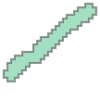

In [10]:
cells=trap_cells[0]
print(cells[1][12])
print(cells[1][12]["GFP"])
cells[1][12]["roiPoly"]

In [ ]:
#%matplotlib inline 

cells_plots_t=[]

for tracked_frame in range(len(cells)):
    this_fig=draw_cell(cells,tracked_frame+1,frame_experiment_start,flims)
    cells_plots_t.append(this_fig)
    plt.close("all")

In [ ]:
#%matplotlib inline 

this_tracked_plots=cells_plots_t
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    



___
# uJ_Tracker: Step 2

In [ ]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
 display: none;
}
</style>

In [ ]:
#global weight_vec
#weight_vec=[-.25,-.25,1,5,-5]
#[distance,angle diff,coverage,axis-intersection,relInt Diff]
%matplotlib ipympl

### Select cells to track

In [ ]:
#%matplotlib inline 
#%matplotlib notebook
%matplotlib ipympl
#%matplotlib widgets

 #if plot does not show,uncomment this line run, comment and re-run


to_track_frame=len(cells)-1
to_track_frame=14
global toTrack_roiIndex
toTrack_roiIndex=[]

global toTrack_roiFrame
toTrack_roiFrame=[]




fig=plt.figure(figsize=(15,15))
#fig=plt.figure()
ax = plt.axes()

plt.xlim(0,640)
plt.ylim(0,512)
#ax.clear()
to_track_polys=[]

for this_cell in cells[to_track_frame]:
    this_poly=this_cell['roiPoly']
    to_track_polys.append(this_poly)
    patch = PolygonPatch(this_poly, facecolor=[0.75,0.75,0.75], edgecolor=[0,0,0], alpha=0.7, zorder=2)
    ax.add_patch(patch)
   #ax.plot(x=100,y=100,c='r*')
ax.axis('off')


#ax.set_aspect('equal')
fig.canvas.layout.width = '1280px'
fig.canvas.layout.height = '1024px'
    

def onclickSelect(event):
    
   #global max_frames
   
   #First find if Point is inside a roi
   this_point = Point(event.xdata,event.ydata)
   
   for select_index, select_poly in enumerate(to_track_polys):
        in_roi=select_poly.contains(this_point)
        if in_roi:
            select_x,select_y = select_poly.exterior.xy     
            ax.plot(select_x, select_y, color='#6699cc', alpha=0.7, linewidth=2, solid_capstyle='round', zorder=3)
            ax.axis('off')
            toTrack_roiIndex.append(select_index)
            toTrack_roiFrame.append(to_track_frame)
           
            break



#cid = fig.canvas.mpl_connect('button_press_event', onclickSelect)
cidx = plt.gcf().canvas.mpl_connect('button_press_event', onclickSelect)



In [ ]:
fig.canvas.mpl_disconnect(cidx)
#%matplotlib inline 

In [ ]:
toTrack_roiIndex

### Track selected cells

In [ ]:
print(toTrack_roiIndex)
print(toTrack_roiFrame)
weight_vec=[-5,-100,200,1000,-55000000,-50,-10]
weight_vec=[-5,-1,150,150,-5,-5]
#weight_vec=[-5,-100,200,500,-5,-5]
#weight_vec=[-4,-800,800,1500,-1,-1]
#[distance,angle diff,coverage,axis-intersection,flourescence Diff]


cells=clear_tracks(cells)
cells_tracked=cells.copy()

cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 

In [ ]:
%matplotlib inline 



tracked_plots=[]
for tindex,trap in enumerate(trap_list):
#    cells_tracked=trap_tracked_cells[tindex]
    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    #for tracked_frame in range(1,max_frames+1):
    for i,tracked_frame in enumerate(frames_list):
#         if(i>15 or i <5):
#             continue
        this_fig=draw_cell(cells_tracked,i+1)
        #plt.show(this_fig)
        figname="%s%s_%s-%s.png"%(dirNameFIGURES,expeLabel,trap,tracked_frame)
        print(figname)
        plt.savefig(figname)
        tracked_plots.append(this_fig)

In [ ]:
#%matplotlib inline 

max_frames=frame_experiment_end-frame_experiment_start+1


this_tracked_plots=tracked_plots
#interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=1,max=max_frames,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    


### Just cells from last frame


In [ ]:
weight_vec=[-5,-100,200,1500,-50,-50,-10]

trap_list2=[trap_list[0]]
trap_tracked_cells=[]
for tindex,trap in enumerate(trap_list2):

    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    
    
    cells=trap_cells[tindex]
    
    cells=clear_tracks(cells)
    cells_tracked=cells.copy()
    

    
    max_frames=len(cells)-1
    #max_frames=len(cells)-1

    from_frame=max_frames
    to_frame=max_frames-1
    
    for this_frame in range(from_frame,to_frame,-1):
        toTrack_roiIndex=[]
        toTrack_roiFrame=[]
        for select_index, this_cell in enumerate(cells_tracked[this_frame]):
            if len(this_cell['trackID'])==0:
                toTrack_roiFrame.append(this_frame)
                toTrack_roiIndex.append(select_index)
        print('\n___\nTracking %s cells from frame %s'%(len(toTrack_roiFrame),this_frame))
        cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 
    print('\n\nTracking complete! Trap:',trap)
    trap_tracked_cells.append(cells_tracked)
    print("\nSaving cells...")
    file_cells= list(f for f in os.listdir(dirNameCELLS) if f.endswith('.pkl'))
    file_cells.sort()
    for frame, this_file in enumerate(file_cells):
        this_cells=cells_tracked[frame] 
        #print(frame, this_file)
        fileNameTrackedCells="%s%s.pkl"%(dirNameTRACKEDCELLS,os.path.splitext(os.path.basename(this_file))[0])    
    #    print(fileNameFrameCells)
        save_cells(this_cells, fileNameTrackedCells)
    

## Tracking All

In [16]:

#[distance,angle diff,coverage,axis-intersection,flourescence Diff]
weight_vec=[-5,-1,150,150,-5,-5]

trap_tracked_cells=[]

for tindex,trap in enumerate(trap_list):
    dirNameCELLS=rootDir+'data_cells/'+trap+'/'+data_type+'/'
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+'/'+data_type+'/'
    
    
    cells=trap_cells[tindex]
    
    cells=clear_tracks(cells)
    cells_tracked=cells.copy()
    
    max_frames=len(cells)-1
    from_frame=max_frames
    to_frame=0
    
    for this_frame in range(from_frame,to_frame,-1):
        toTrack_roiIndex=[]
        toTrack_roiFrame=[]
        for select_index, this_cell in enumerate(cells_tracked[this_frame]):
            if len(this_cell['trackID'])==0:
                toTrack_roiFrame.append(this_frame)
                toTrack_roiIndex.append(select_index)
        print('\n___\nTracking %s cells from frame %s'%(len(toTrack_roiFrame),this_frame+frame_experiment_start))
        cells_tracked=track_this_indexs(toTrack_roiIndex,toTrack_roiFrame,cells_tracked,weight_vec) 
    print('\n\nTracking complete! Trap:',trap)
    trap_tracked_cells.append(cells_tracked)
    print("\nSaving cells...")
    file_cells= list(f for f in os.listdir(dirNameCELLS) if f.endswith('.pkl'))
    file_cells.sort()
    for frame, this_file in enumerate(file_cells):
        this_cells=cells_tracked[frame] 
        #print(frame, this_file)
        fileNameTrackedCells="%s%s.pkl"%(dirNameTRACKEDCELLS,os.path.splitext(os.path.basename(this_file))[0])    
    #    print(fileNameFrameCells)
        save_cells(this_cells, fileNameTrackedCells)
    


___
Tracking 14 cells from frame 44
14/14
___
Tracking 2 cells from frame 43
2/2
___
Tracking 0 cells from frame 42

___
Tracking 3 cells from frame 41
3/3
___
Tracking 11 cells from frame 40
11/11
___
Tracking 6 cells from frame 39
6/6
___
Tracking 5 cells from frame 38
5/5
___
Tracking 6 cells from frame 37
6/6
___
Tracking 6 cells from frame 36
6/6
___
Tracking 4 cells from frame 35
4/4
___
Tracking 5 cells from frame 34
5/5
___
Tracking 6 cells from frame 33
6/6
___
Tracking 19 cells from frame 32
19/19
___
Tracking 14 cells from frame 31
14/14
___
Tracking 13 cells from frame 30
13/13
___
Tracking 10 cells from frame 29
10/10
___
Tracking 8 cells from frame 28
8/8
___
Tracking 18 cells from frame 27
18/18
___
Tracking 11 cells from frame 26
11/11
___
Tracking 13 cells from frame 25
13/13
___
Tracking 4 cells from frame 24
4/4
___
Tracking 4 cells from frame 23
4/4
___
Tracking 5 cells from frame 22
5/5
___
Tracking 6 cells from frame 21
6/6

Tracking complete! Trap: xy01

Saving 

Saving 114 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_038.pkl
Saving 114 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_039.pkl
Saving 115 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_040.pkl
Saving 120 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_041.pkl
Saving 123 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_042.pkl
Saving 133 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy02/normData/pBGT-AMP-Pulse_xy02_043.pkl
Saving 129

Saving 121 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_029.pkl
Saving 106 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_030.pkl
Saving 105 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_031.pkl
Saving 110 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_032.pkl
Saving 110 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_033.pkl
Saving 106 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy11/normData/pBGT-AMP-Pulse_xy11_034.pkl
Saving 116

3/3
___
Tracking 5 cells from frame 34
5/5
___
Tracking 6 cells from frame 33
6/6
___
Tracking 11 cells from frame 32
11/11
___
Tracking 7 cells from frame 31
7/7
___
Tracking 10 cells from frame 30
10/10
___
Tracking 13 cells from frame 29
13/13
___
Tracking 13 cells from frame 28
13/13
___
Tracking 14 cells from frame 27
14/14
___
Tracking 9 cells from frame 26
9/9
___
Tracking 21 cells from frame 25
21/21
___
Tracking 29 cells from frame 24
29/29
___
Tracking 63 cells from frame 23
63/63
___
Tracking 41 cells from frame 22
41/41
___
Tracking 16 cells from frame 21
16/16

Tracking complete! Trap: xy13

Saving cells...
Saving 236 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy13/normData/pBGT-AMP-Pulse_xy13_020.pkl
Saving 235 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy13/normData/pBGT-AMP-Pulse_xy13_021.pkl
Saving 233 cells to /home/charly/Lab/Proje

Saving 130 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_039.pkl
Saving 125 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_040.pkl
Saving 118 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_041.pkl
Saving 113 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_042.pkl
Saving 114 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_043.pkl
Saving 115 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy14/normData/pBGT-AMP-Pulse_xy14_044.pkl

___
Track

Saving 175 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_027.pkl
Saving 177 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_028.pkl
Saving 170 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_029.pkl
Saving 167 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_030.pkl
Saving 165 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_031.pkl
Saving 159 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy21/normData/pBGT-AMP-Pulse_xy21_032.pkl
Saving 143

32/32
___
Tracking 33 cells from frame 42
33/33
___
Tracking 34 cells from frame 41
34/34
___
Tracking 19 cells from frame 40
19/19
___
Tracking 21 cells from frame 39
21/21
___
Tracking 15 cells from frame 38
15/15
___
Tracking 31 cells from frame 37
31/31
___
Tracking 22 cells from frame 36
22/22
___
Tracking 12 cells from frame 35
12/12
___
Tracking 8 cells from frame 34
8/8
___
Tracking 12 cells from frame 33
12/12
___
Tracking 29 cells from frame 32
29/29
___
Tracking 22 cells from frame 31
22/22
___
Tracking 30 cells from frame 30
30/30
___
Tracking 21 cells from frame 29
21/21
___
Tracking 20 cells from frame 28
20/20
___
Tracking 35 cells from frame 27
35/35
___
Tracking 29 cells from frame 26
29/29
___
Tracking 31 cells from frame 25
31/31
___
Tracking 30 cells from frame 24
30/30
___
Tracking 29 cells from frame 23
29/29
___
Tracking 24 cells from frame 22
24/24
___
Tracking 38 cells from frame 21
38/38

Tracking complete! Trap: xy23

Saving cells...
Saving 164 cells to /home

Saving 88 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_033.pkl
Saving 78 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_034.pkl
Saving 76 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_035.pkl
Saving 76 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_036.pkl
Saving 76 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_037.pkl
Saving 74 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy25/normData/pBGT-AMP-Pulse_xy25_038.pkl
Saving 72 cells 

Saving 257 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_023.pkl
Saving 256 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_024.pkl
Saving 244 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_025.pkl
Saving 244 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_026.pkl
Saving 239 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_027.pkl
Saving 225 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy27/normData/pBGT-AMP-Pulse_xy27_028.pkl
Saving 212


___
Tracking 105 cells from frame 44
105/105
___
Tracking 4 cells from frame 43
4/4
___
Tracking 5 cells from frame 42
5/5
___
Tracking 6 cells from frame 41
6/6
___
Tracking 10 cells from frame 40
10/10
___
Tracking 5 cells from frame 39
5/5
___
Tracking 3 cells from frame 38
3/3
___
Tracking 2 cells from frame 37
2/2
___
Tracking 3 cells from frame 36
3/3
___
Tracking 11 cells from frame 35
11/11
___
Tracking 4 cells from frame 34
4/4
___
Tracking 18 cells from frame 33
18/18
___
Tracking 5 cells from frame 32
5/5
___
Tracking 9 cells from frame 31
9/9
___
Tracking 14 cells from frame 30
14/14
___
Tracking 9 cells from frame 29
9/9
___
Tracking 9 cells from frame 28
9/9
___
Tracking 9 cells from frame 27
9/9
___
Tracking 1 cells from frame 26
1/1
___
Tracking 10 cells from frame 25
10/10
___
Tracking 21 cells from frame 24
21/21
___
Tracking 15 cells from frame 23
15/15
___
Tracking 23 cells from frame 22
23/23
___
Tracking 12 cells from frame 21
12/12

Tracking complete! Trap: xy29

Saving 108 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_036.pkl
Saving 110 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_037.pkl
Saving 101 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_038.pkl
Saving 97 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_039.pkl
Saving 92 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_040.pkl
Saving 92 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy30/normData/pBGT-AMP-Pulse_xy30_041.pkl
Saving 88 cel

Saving 391 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_023.pkl
Saving 387 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_024.pkl
Saving 380 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_025.pkl
Saving 388 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_026.pkl
Saving 385 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_027.pkl
Saving 365 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy34/normData/pBGT-AMP-Pulse_xy34_028.pkl
Saving 351

Saving 176 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy35/normData/pBGT-AMP-Pulse_xy35_043.pkl
Saving 169 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy35/normData/pBGT-AMP-Pulse_xy35_044.pkl

___
Tracking 139 cells from frame 44
139/139
___
Tracking 8 cells from frame 43
8/8
___
Tracking 10 cells from frame 42
10/10
___
Tracking 10 cells from frame 41
10/10
___
Tracking 3 cells from frame 40
3/3
___
Tracking 8 cells from frame 39
8/8
___
Tracking 6 cells from frame 38
6/6
___
Tracking 4 cells from frame 37
4/4
___
Tracking 5 cells from frame 36
5/5
___
Tracking 6 cells from frame 35
6/6
___
Tracking 24 cells from frame 34
24/24
___
Tracking 34 cells from frame 33
34/34
___
Tracking 13 cells from frame 32
13/13
___
Tracking 8 cells from frame 31
8/8
___
Tracking 20 cells from frame 30
20/20
___
Tracking 6 cells from frame 29
6/6
___
Tracking 25 cells

Saving 179 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_033.pkl
Saving 155 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_034.pkl
Saving 154 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_035.pkl
Saving 151 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_036.pkl
Saving 151 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_037.pkl
Saving 148 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy37/normData/pBGT-AMP-Pulse_xy37_038.pkl
Saving 151

Saving 141 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_023.pkl
Saving 139 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_024.pkl
Saving 137 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_025.pkl
Saving 137 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_026.pkl
Saving 124 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_027.pkl
Saving 123 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy40/normData/pBGT-AMP-Pulse_xy40_028.pkl
Saving 114


___
Tracking 158 cells from frame 44
158/158
___
Tracking 1 cells from frame 43
1/1
___
Tracking 3 cells from frame 42
3/3
___
Tracking 4 cells from frame 41
4/4
___
Tracking 4 cells from frame 40
4/4
___
Tracking 4 cells from frame 39
4/4
___
Tracking 4 cells from frame 38
4/4
___
Tracking 2 cells from frame 37
2/2
___
Tracking 7 cells from frame 36
7/7
___
Tracking 4 cells from frame 35
4/4
___
Tracking 5 cells from frame 34
5/5
___
Tracking 10 cells from frame 33
10/10
___
Tracking 10 cells from frame 32
10/10
___
Tracking 13 cells from frame 31
13/13
___
Tracking 23 cells from frame 30
23/23
___
Tracking 24 cells from frame 29
24/24
___
Tracking 27 cells from frame 28
27/27
___
Tracking 21 cells from frame 27
21/21
___
Tracking 14 cells from frame 26
14/14
___
Tracking 8 cells from frame 25
8/8
___
Tracking 15 cells from frame 24
15/15
___
Tracking 12 cells from frame 23
12/12
___
Tracking 29 cells from frame 22
29/29
___
Tracking 40 cells from frame 21
40/40

Tracking complete! T

Saving 161 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_034.pkl
Saving 150 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_035.pkl
Saving 141 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_036.pkl
Saving 137 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_037.pkl
Saving 140 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_038.pkl
Saving 138 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy43/normData/pBGT-AMP-Pulse_xy43_039.pkl
Saving 138

Saving 249 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_023.pkl
Saving 238 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_024.pkl
Saving 224 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_025.pkl
Saving 223 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_026.pkl
Saving 219 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_027.pkl
Saving 203 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy45/normData/pBGT-AMP-Pulse_xy45_028.pkl
Saving 187

Saving 191 cells to /home/charly/Lab/Projects/uJ/uJ_data/pBGT-AMP-Pulse/20190325_Bruno_pBGT_quimiostato/data_cells_tracked/xy46/normData/pBGT-AMP-Pulse_xy46_044.pkl

___
Tracking 118 cells from frame 44
118/118
___
Tracking 12 cells from frame 43
12/12
___
Tracking 20 cells from frame 42
20/20
___
Tracking 16 cells from frame 41
16/16
___
Tracking 8 cells from frame 40
8/8
___
Tracking 7 cells from frame 39
7/7
___
Tracking 14 cells from frame 38
14/14
___
Tracking 12 cells from frame 37
12/12
___
Tracking 14 cells from frame 36
14/14
___
Tracking 14 cells from frame 35
14/14
___
Tracking 5 cells from frame 34
5/5
___
Tracking 16 cells from frame 33
16/16
___
Tracking 4 cells from frame 32
4/4
___
Tracking 10 cells from frame 31
10/10
___
Tracking 15 cells from frame 30
15/15
___
Tracking 13 cells from frame 29
13/13
___
Tracking 13 cells from frame 28
13/13
___
Tracking 10 cells from frame 27
10/10
___
Tracking 11 cells from frame 26
11/11
___
Tracking 9 cells from frame 25
9/9
___
Tr

In [ ]:
trap_tracked_cells[0][0][1]

### Load tracked cells

In [ ]:
max_frames2=-1

trap_tracked_cells=[]
for trap in trap_list:
    dirNameTRACKEDCELLS=rootDir+'data_cells_tracked/'+trap+"/"+data_type+"/"
    tracked_cells=load_cells(dirNameTRACKEDCELLS,max_frames2)
    trap_tracked_cells.append(tracked_cells)

### Draw ROIs + Tracked Cells

In [ ]:
trap_list

In [ ]:
%matplotlib inline
#max_frames=len(cells_tracked)
trap_tracked_plots=[]
for tindex,trap in enumerate(trap_list):
    tracked_plots=[]
    cells_tracked=trap_tracked_cells[tindex]
    dirNameFIGURES=rootDir+'figures/traked_cells/'+trap+'/'+data_type+'/'
    print("Trap: %s in %s"%(trap,dirNameFIGURES))
    for i,tracked_frame in enumerate(frames_list):
        this_fig=draw_cell(cells_tracked,i+1,frame_experiment_start,flims)
        #plt.show(this_fig)
        tracked_frame_name=str(tracked_frame).zfill(3)
        figname="%s%s_%s-%s.png"%(dirNameFIGURES,expeLabel,trap,tracked_frame_name)
        this_fig.savefig(figname)
        tracked_plots.append(this_fig)
       # display(this_fig)
        plt.close("all")
    print()
    trap_tracked_plots.append(tracked_plots)

In [ ]:
len(trap_tracked_plots)

In [ ]:
#%matplotlib inline 

max_frames=frame_experiment_end-frame_experiment_start+1


this_tracked_plots=trap_tracked_plots[5]
#interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=1,max=max_frames,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot=interactive(show_all,this_tracked_plots=fixed(this_tracked_plots),tracked_frame=widgets.IntSlider(min=frame_experiment_start,max=frame_experiment_end,step=1,value=1),fs=fixed(frame_experiment_start))
interactive_plot    



In [ ]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
 display: none;
}
</style>